In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from data import Burgers_Dataset
from unet2d import Unet2D
from diffuser import GaussianDiffusion

In [2]:
ds = Burgers_Dataset("../data/burgers_data_Nt100_v1e-02_N200.mat", normalize=False)

Loaded 200 samples from ../data/burgers_data_Nt100_v1e-02_N200.mat
Shape of x: torch.Size([200, 1, 100, 128])


In [3]:
model = Unet2D(
    channels=1,
    cond_channels=1,
    channel_mults=(1, 2, 4, 8),
    init_conv_channels=32,
    init_conv_kernel_size=5
)
diffusion_model = GaussianDiffusion(
    model=model,
    sample_size=(1, 100, 128),
    timesteps=800,
    objective='pred_x0',
    physics_loss_weight=0.0
).to("cuda:1")

In [4]:
x = ds[-8:]['x']
y = ds[-8:]['y']

In [5]:
def make_prediction(diffuser, cond, physics_loss_weight, use_res_diff):
    if use_res_diff:
        diffuser.model.load_state_dict(torch.load(f"./ckpts/burgers_{physics_loss_weight:.2f}phyloss_resdiff/ckpt_clean.pt"))
    else:
        diffuser.model.load_state_dict(torch.load(f"./ckpts/burgers_{physics_loss_weight:.2f}phyloss/ckpt.pt")['model_state_dict'])
    x_pred = diffuser.sample(cond)

    return x_pred.cpu().numpy().squeeze()

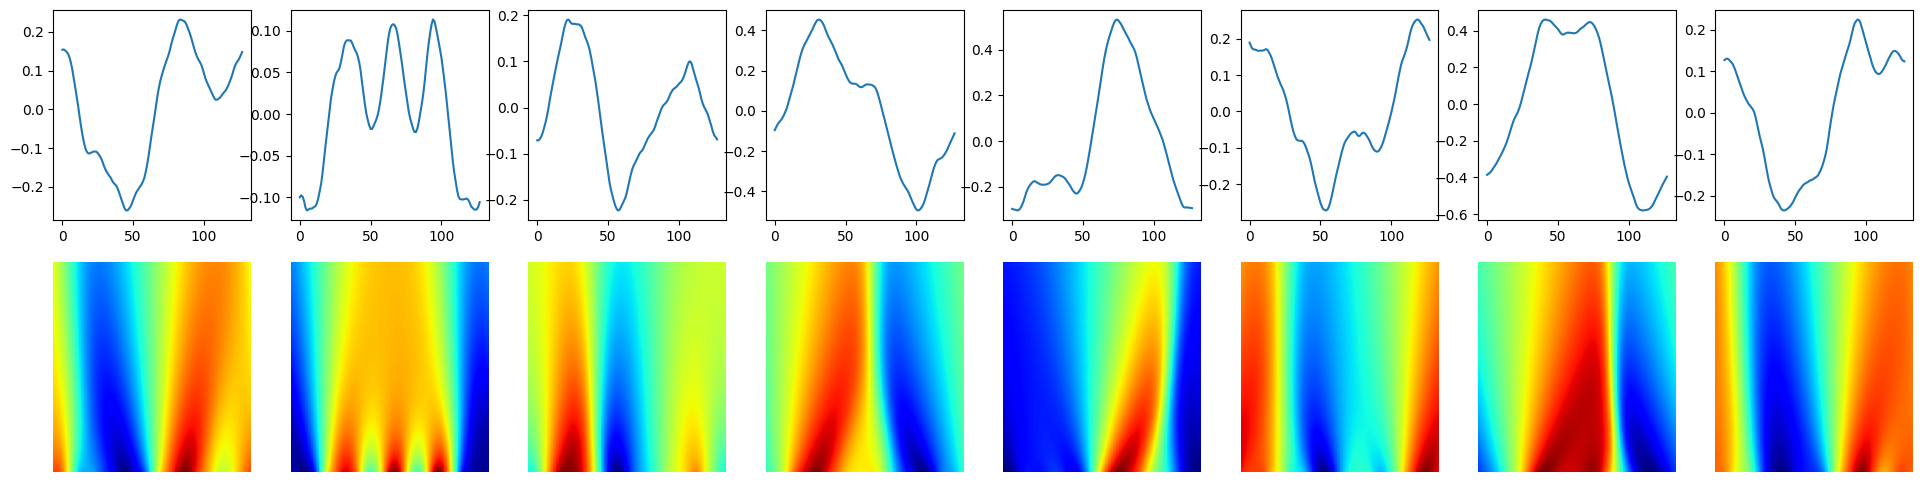

In [6]:
fig, ax = plt.subplots(2, 8, figsize=(24, 6))
for i in range(8):
    ax[0, i].plot(y[i, 0, :])

    ax[1, i].imshow(x[i, 0, :, :], cmap='jet', origin='lower', aspect='auto')
    ax[1, i].set_axis_off()

In [7]:
x_pred000 = make_prediction(diffusion_model, y, 0.0, False)
# x_pred005 = make_prediction(diffusion_model, y, 0.05, False)
# x_pred010 = make_prediction(diffusion_model, y, 0.1, False)
# x_pred020 = make_prediction(diffusion_model, y, 0.2, False)
# # x_pred000_cal = make_prediction(diffusion_model, y, 0.0, True)
# x_pred005_cal = make_prediction(diffusion_model, y, 0.05, True)
# x_pred010_cal = make_prediction(diffusion_model, y, 0.1, True)
# x_pred020_cal = make_prediction(diffusion_model, y, 0.2, True)

DDPM sampling: 100%|██████████| 800/800 [01:13<00:00, 10.92it/s]


In [8]:
x_span = np.linspace(0, 1, 128)
t_span = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_span, t_span)

In [9]:
x = x.numpy().squeeze()
y = y.numpy().squeeze()

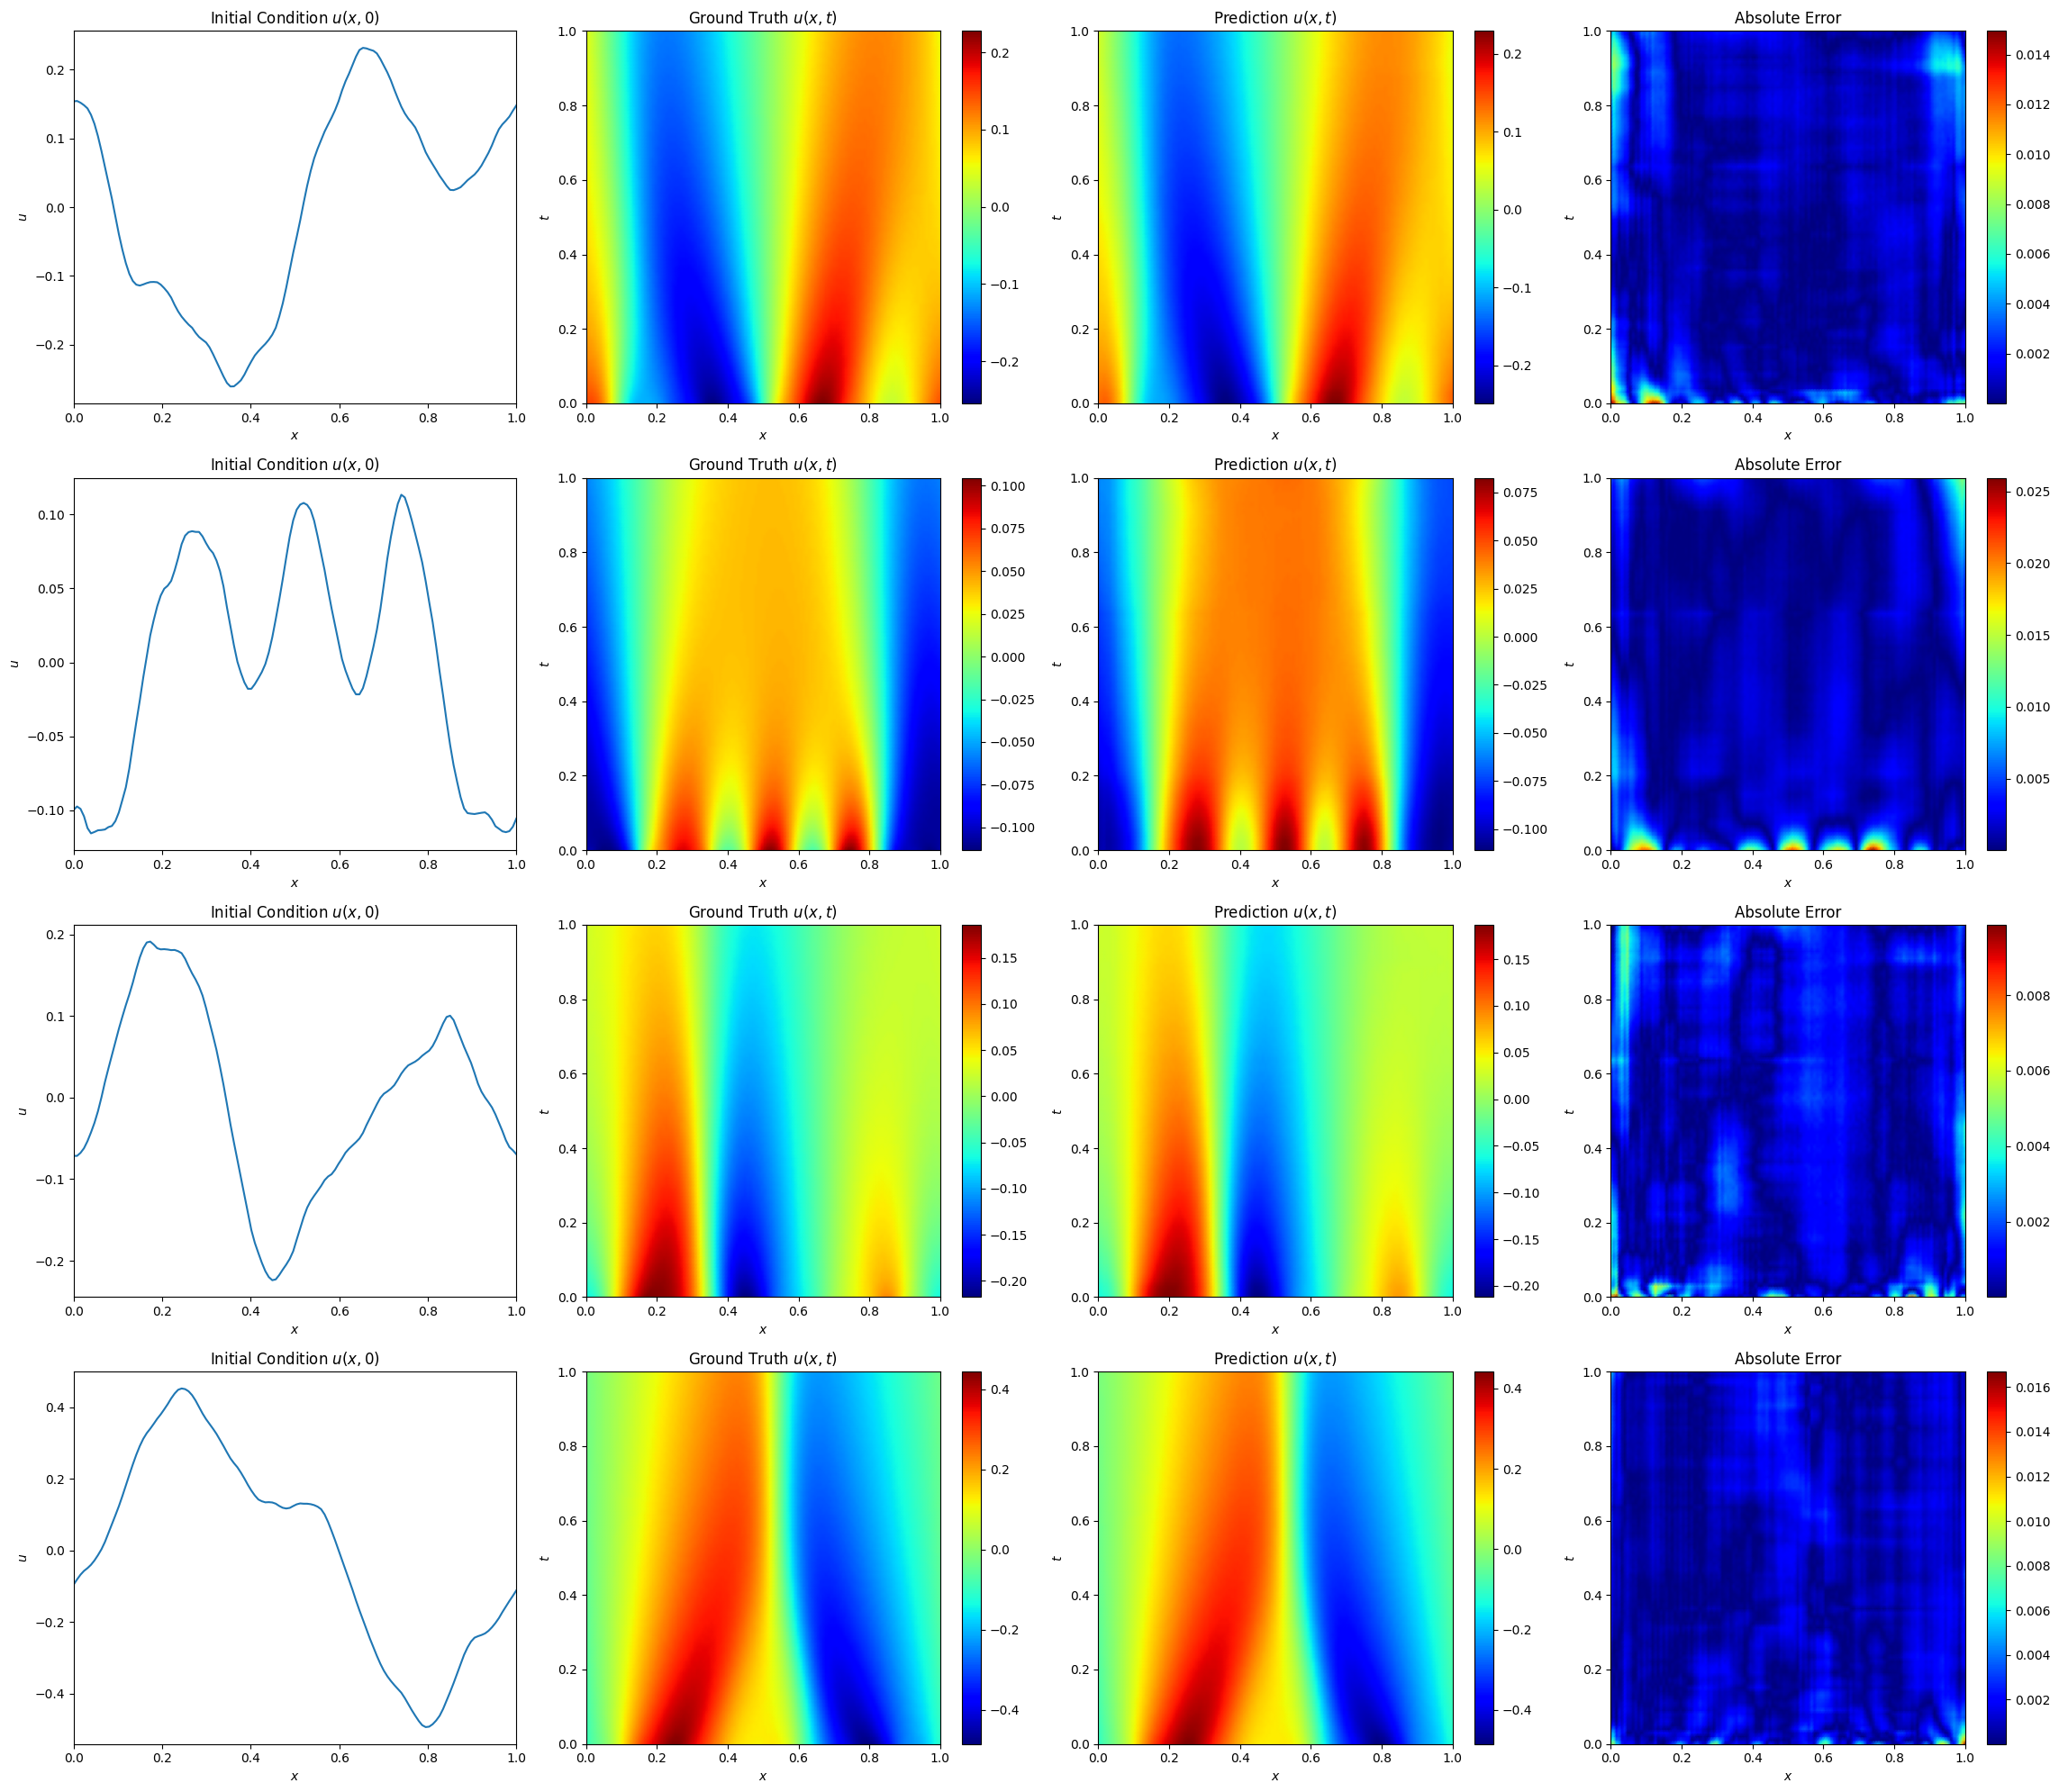

In [10]:
fig, ax = plt.subplots(4, 4, figsize=(23, 20))
for i in range(4):
    ax[i, 0].plot(x_span, y[i].squeeze())
    ax[i, 0].set_xlabel('$x$')
    ax[i, 0].set_ylabel('$u$')
    ax[i, 0].set_title('Initial Condition $u(x, 0)$')
    ax[i, 0].set_xlim([0, 1])
    plt.tight_layout()

    im1 = ax[i, 1].pcolormesh(X, T, x[i], cmap='jet', shading='gouraud')
    ax[i, 1].set_xlabel('$x$')
    ax[i, 1].set_ylabel('$t$')
    ax[i, 1].set_title('Ground Truth $u(x, t)$')
    # ax[i, 1].set_axis('square')
    fig.colorbar(im1, ax=ax[i, 1])
    plt.tight_layout()

    im2 = ax[i, 2].pcolormesh(X, T, x_pred000[i], cmap='jet', shading='gouraud')
    ax[i, 2].set_xlabel('$x$')
    ax[i, 2].set_ylabel('$t$')
    ax[i, 2].set_title('Prediction $u(x, t)$')
    # ax[i, 2].set_axis('square')
    fig.colorbar(im2, ax=ax[i, 2])
    plt.tight_layout()

    im3 = ax[i, 3].pcolormesh(X, T, np.abs(x[i]-x_pred000[i]), cmap='jet', shading='gouraud')
    ax[i, 3].set_xlabel('$x$')
    ax[i, 3].set_ylabel('$t$')
    ax[i, 3].set_title('Absolute Error')
    # ax[i, 3].set_axis('square')
    fig.colorbar(im3, ax=ax[i, 3])
    plt.tight_layout()

In [14]:
fig.savefig('../assets/burgers_exp1.png', bbox_inches='tight')

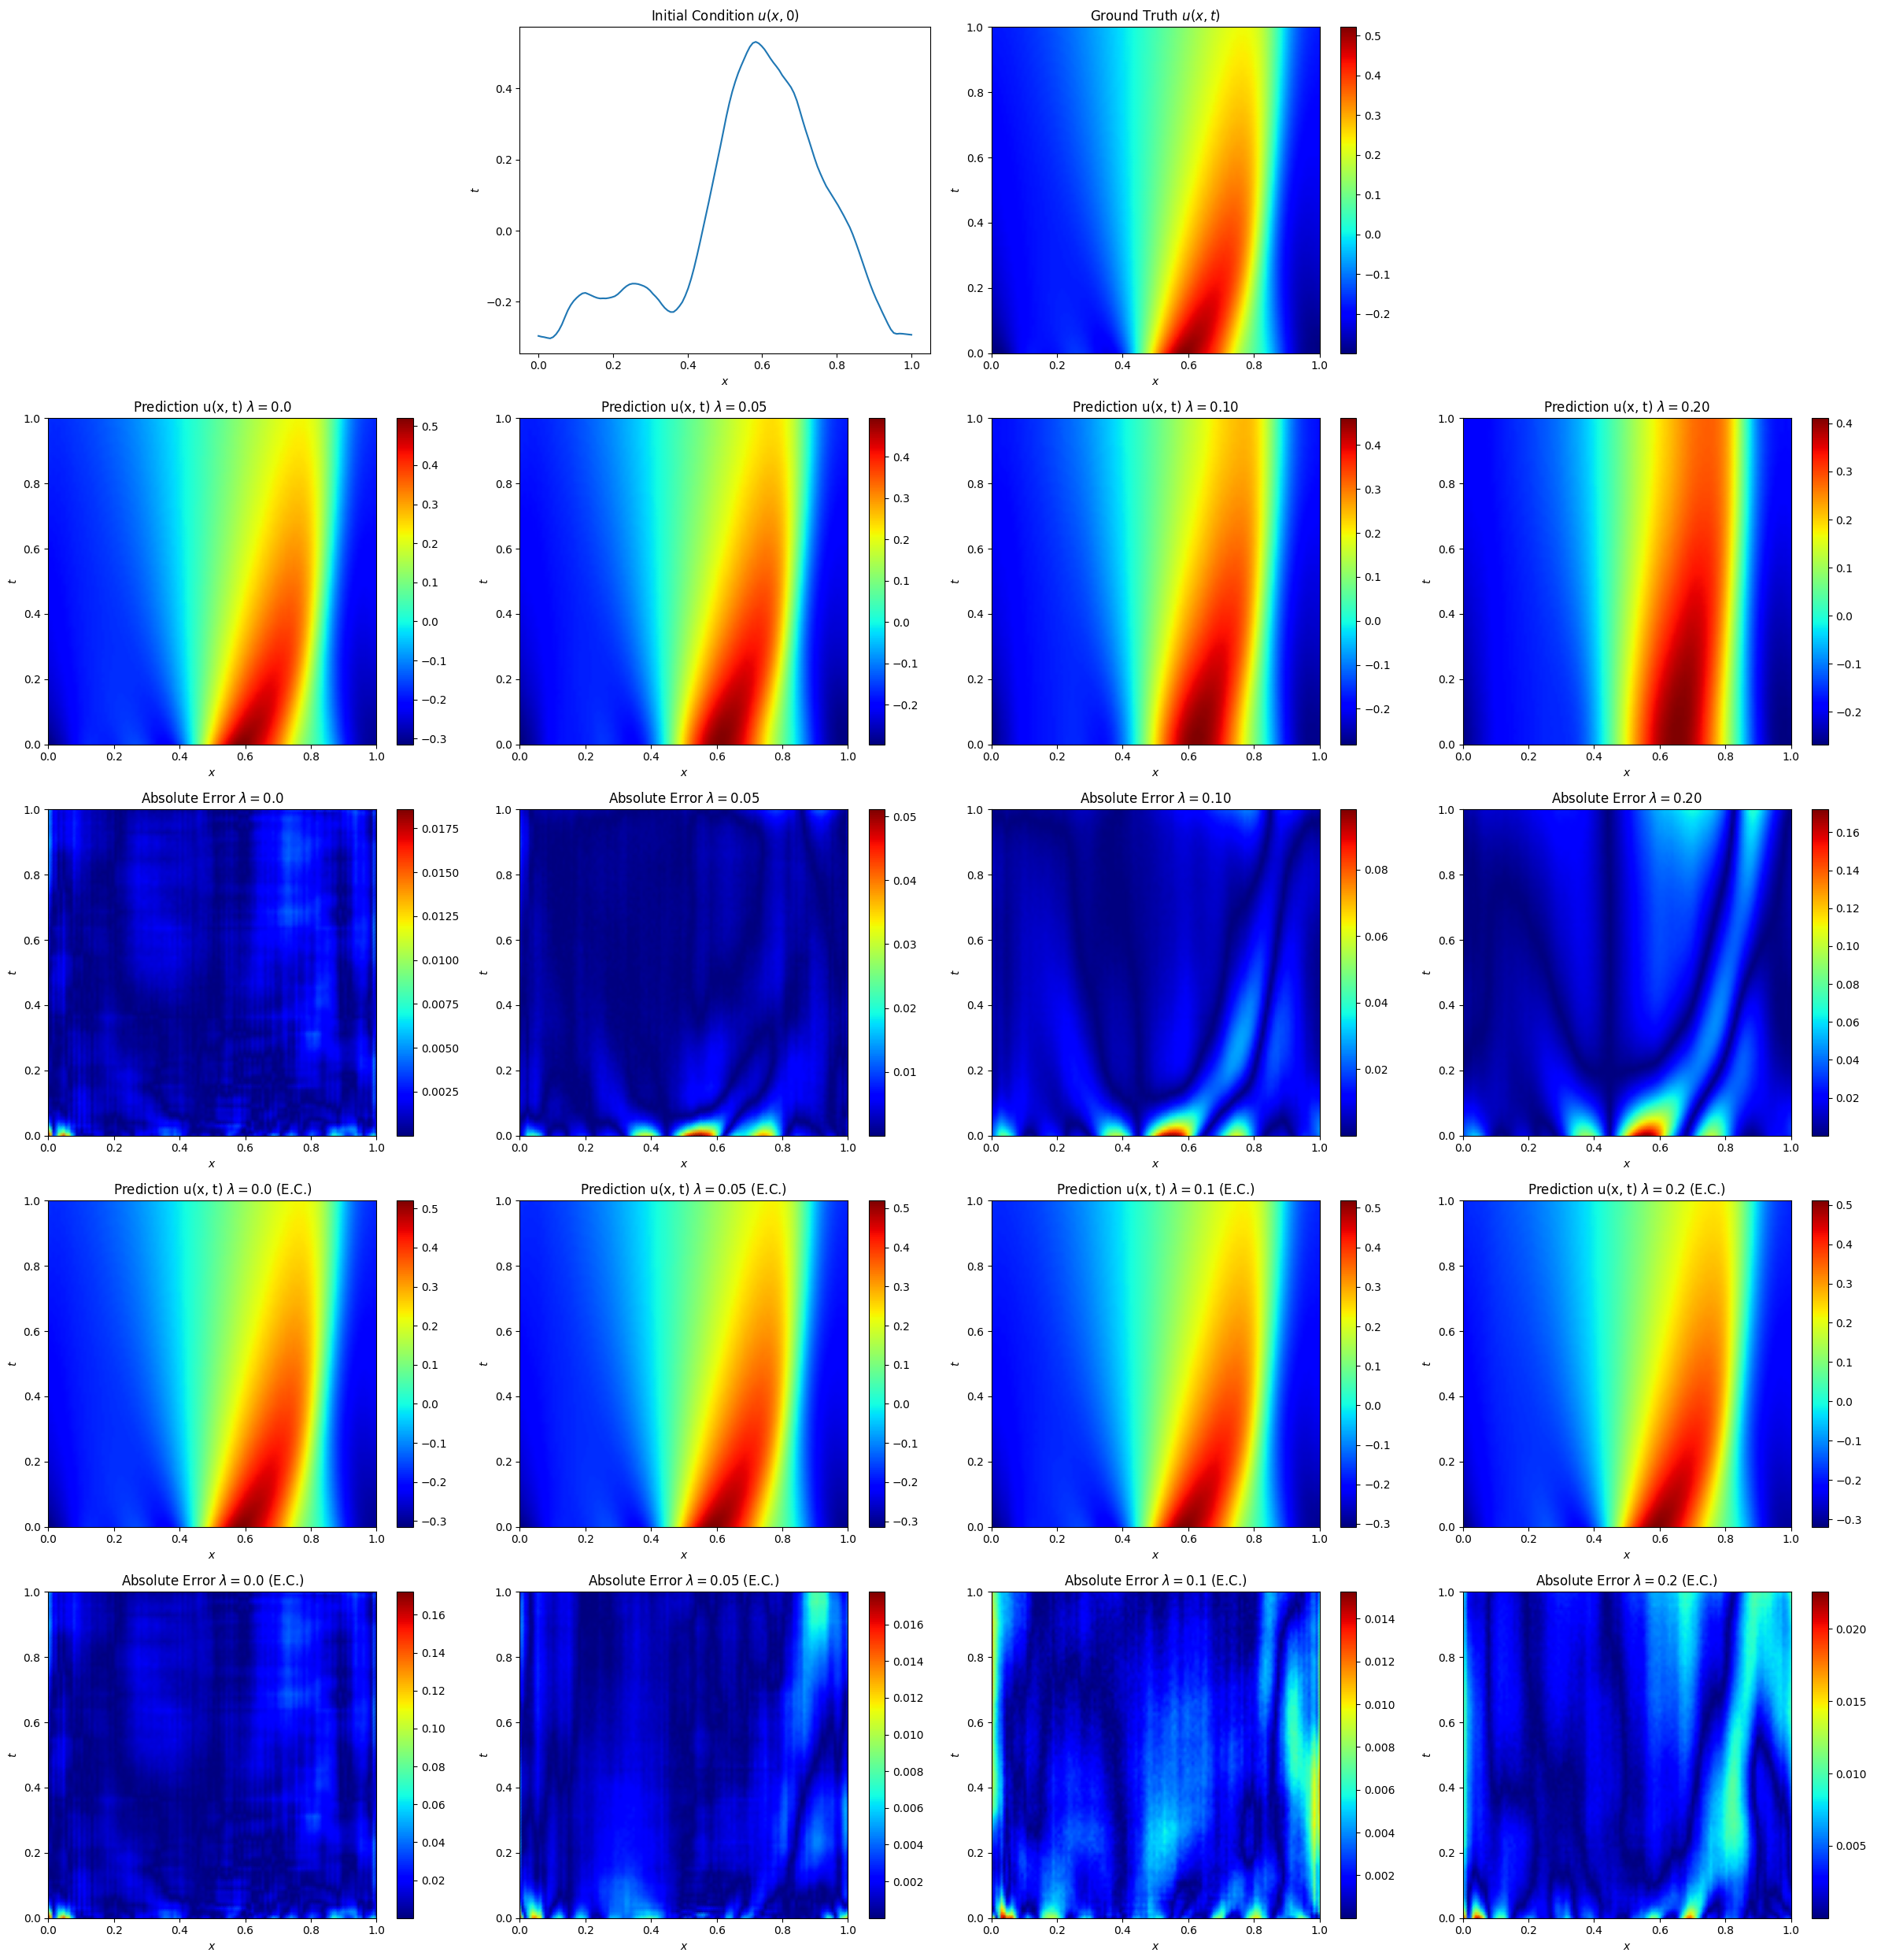

In [16]:
n = 4
fig, ax = plt.subplots(5, 4, figsize=(24, 25))
ax[0, 0].set_axis_off()
ax[0, 3].set_axis_off()

im1 = ax[0, 1].plot(x_span, y[n].squeeze())
ax[0, 1].set_xlabel('$x$')
ax[0, 1].set_ylabel('$t$')
ax[0, 1].set_title('Initial Condition $u(x, 0)$')
plt.tight_layout()

im2 = ax[0, 2].pcolormesh(X, T, x[n], shading='gouraud', cmap='jet')
ax[0, 2].set_xlabel('$x$')
ax[0, 2].set_ylabel('$t$')
ax[0, 2].set_title('Ground Truth $u(x, t)$')
fig.colorbar(im2, ax=ax[0, 2])
plt.tight_layout()

im3 = ax[1, 0].pcolormesh(X, T, x_pred000[n], shading='gouraud', cmap='jet')
ax[1, 0].set_xlabel('$x$')
ax[1, 0].set_ylabel('$t$')
ax[1, 0].set_title(r'Prediction u(x, t) $\lambda=0.0$')
fig.colorbar(im3, ax=ax[1, 0])
plt.tight_layout()

im4 = ax[1, 1].pcolormesh(X, T, x_pred005[n], shading='gouraud', cmap='jet')
ax[1, 1].set_xlabel('$x$')
ax[1, 1].set_ylabel('$t$')
ax[1, 1].set_title(r'Prediction u(x, t) $\lambda=0.05$')
fig.colorbar(im4, ax=ax[1, 1])
plt.tight_layout()

im5 = ax[1, 2].pcolormesh(X, T, x_pred010[n], shading='gouraud', cmap='jet')
ax[1, 2].set_xlabel('$x$')
ax[1, 2].set_ylabel('$t$')
ax[1, 2].set_title(r'Prediction u(x, t) $\lambda=0.10$')
fig.colorbar(im5, ax=ax[1, 2])
plt.tight_layout()

im6 = ax[1, 3].pcolormesh(X, T, x_pred020[n], shading='gouraud', cmap='jet')
ax[1, 3].set_xlabel('$x$')
ax[1, 3].set_ylabel('$t$')
ax[1, 3].set_title(r'Prediction u(x, t) $\lambda=0.20$')
fig.colorbar(im6, ax=ax[1, 3])
plt.tight_layout()

im7 = ax[2, 0].pcolormesh(X, T, np.abs(x_pred000[n]-x[n]), shading='gouraud', cmap='jet')
ax[2, 0].set_xlabel('$x$')
ax[2, 0].set_ylabel('$t$')
ax[2, 0].set_title(r'Absolute Error $\lambda=0.0$')
fig.colorbar(im7, ax=ax[2, 0])
plt.tight_layout()

im8 = ax[2, 1].pcolormesh(X, T, np.abs(x_pred005[n]-x[n]), shading='gouraud', cmap='jet')
ax[2, 1].set_xlabel('$x$')
ax[2, 1].set_ylabel('$t$')
ax[2, 1].set_title(r'Absolute Error $\lambda=0.05$')
fig.colorbar(im8, ax=ax[2, 1])
plt.tight_layout()

im9 = ax[2, 2].pcolormesh(X, T, np.abs(x_pred010[n]-x[n]), shading='gouraud', cmap='jet')
ax[2, 2].set_xlabel('$x$')
ax[2, 2].set_ylabel('$t$')
ax[2, 2].set_title(r'Absolute Error $\lambda=0.10$')
fig.colorbar(im9, ax=ax[2, 2])
plt.tight_layout()

im10 = ax[2, 3].pcolormesh(X, T, np.abs(x_pred020[n]-x[n]), shading='gouraud', cmap='jet')
ax[2, 3].set_xlabel('$x$')
ax[2, 3].set_ylabel('$t$')
ax[2, 3].set_title(r'Absolute Error $\lambda=0.20$')
fig.colorbar(im10, ax=ax[2, 3])
plt.tight_layout()

im11 = ax[3, 0].pcolormesh(X, T, x_pred000[n], shading='gouraud', cmap='jet')
ax[3, 0].set_xlabel('$x$')
ax[3, 0].set_ylabel('$t$')
ax[3, 0].set_title(r'Prediction u(x, t) $\lambda=0.0$ (E.C.)')
fig.colorbar(im11, ax=ax[3, 0])
plt.tight_layout()

im12 = ax[3, 1].pcolormesh(X, T, x_pred005_cal[n], shading='gouraud', cmap='jet')
ax[3, 1].set_xlabel('$x$')
ax[3, 1].set_ylabel('$t$')
ax[3, 1].set_title(r'Prediction u(x, t) $\lambda=0.05$ (E.C.)')
fig.colorbar(im12, ax=ax[3, 1])
plt.tight_layout()

im13 = ax[3, 2].pcolormesh(X, T, x_pred010_cal[n], shading='gouraud', cmap='jet')
ax[3, 2].set_xlabel('$x$')
ax[3, 2].set_ylabel('$t$')
ax[3, 2].set_title(r'Prediction u(x, t) $\lambda=0.1$ (E.C.)')
fig.colorbar(im13, ax=ax[3, 2])
plt.tight_layout()

im14 = ax[3, 3].pcolormesh(X, T, x_pred020_cal[n], shading='gouraud', cmap='jet')
ax[3, 3].set_xlabel('$x$')
ax[3, 3].set_ylabel('$t$')
ax[3, 3].set_title(r'Prediction u(x, t) $\lambda=0.2$ (E.C.)')
fig.colorbar(im14, ax=ax[3, 3])
plt.tight_layout()

im15 = ax[4, 0].pcolormesh(X, T, np.abs(x_pred000[n]-x[n]), shading='gouraud', cmap='jet')
ax[4, 0].set_xlabel('$x$')
ax[4, 0].set_ylabel('$t$')
ax[4, 0].set_title(r'Absolute Error $\lambda=0.0$ (E.C.)')
fig.colorbar(im10, ax=ax[4, 0])
plt.tight_layout()

im16 = ax[4, 1].pcolormesh(X, T, np.abs(x_pred005_cal[n]-x[n]), shading='gouraud', cmap='jet')
ax[4, 1].set_xlabel('$x$')
ax[4, 1].set_ylabel('$t$')
ax[4, 1].set_title(r'Absolute Error $\lambda=0.05$ (E.C.)')
fig.colorbar(im16, ax=ax[4, 1])
plt.tight_layout()

im17 = ax[4, 2].pcolormesh(X, T, np.abs(x_pred010_cal[n]-x[n]), shading='gouraud', cmap='jet')
ax[4, 2].set_xlabel('$x$')
ax[4, 2].set_ylabel('$t$')
ax[4, 2].set_title(r'Absolute Error $\lambda=0.1$ (E.C.)')
fig.colorbar(im17, ax=ax[4, 2])
plt.tight_layout()

im18 = ax[4, 3].pcolormesh(X, T, np.abs(x_pred020_cal[n]-x[n]), shading='gouraud', cmap='jet')
ax[4, 3].set_xlabel('$x$')
ax[4, 3].set_ylabel('$t$')
ax[4, 3].set_title(r'Absolute Error $\lambda=0.2$ (E.C.)')
fig.colorbar(im18, ax=ax[4, 3])
plt.tight_layout()

In [17]:
fig.savefig('../assets/burgers_exp2.png', bbox_inches='tight')

In [48]:
def cal_nRMSE(x, x_pred):
    mean = np.sqrt(np.mean((x-x_pred)**2))/np.sqrt(np.mean(x**2))
    std = mean / np.sqrt(2 * x.shape[0])
    return {'mean': mean, 'std': std}

In [49]:
nRMSE000 = cal_nRMSE(x, x_pred000)
nRMSE005 = cal_nRMSE(x, x_pred005)
nRMSE010 = cal_nRMSE(x, x_pred010)
nRMSE020 = cal_nRMSE(x, x_pred020)
nRMSE000_cal = nRMSE000
nRMSE005_cal = cal_nRMSE(x, x_pred005_cal)
nRMSE010_cal = cal_nRMSE(x, x_pred010_cal)
nRMSE020_cal = cal_nRMSE(x, x_pred020_cal)

In [50]:
print(f"nRMSE for 0.00 physics loss: {nRMSE000['mean']:.4f} ± {nRMSE000['std']:.4f}")
print(f"nRMSE for 0.05 physics loss: {nRMSE005['mean']:.4f} ± {nRMSE005['std']:.4f}")
print(f"nRMSE for 0.10 physics loss: {nRMSE010['mean']:.4f} ± {nRMSE010['std']:.4f}")
print(f"nRMSE for 0.20 physics loss: {nRMSE020['mean']:.4f} ± {nRMSE020['std']:.4f}")
print(f"nRMSE for 0.00 physics loss (E.C.): {nRMSE000_cal['mean']:.4f} ± {nRMSE000_cal['std']:.4f}")
print(f"nRMSE for 0.05 physics loss (E.C.): {nRMSE005_cal['mean']:.4f} ± {nRMSE005_cal['std']:.4f}")
print(f"nRMSE for 0.10 physics loss (E.C.): {nRMSE010_cal['mean']:.4f} ± {nRMSE010_cal['std']:.4f}")
print(f"nRMSE for 0.20 physics loss (E.C.): {nRMSE020_cal['mean']:.4f} ± {nRMSE020_cal['std']:.4f}")

nRMSE for 0.00 physics loss: 0.0104 ± 0.0026
nRMSE for 0.05 physics loss: 0.0214 ± 0.0054
nRMSE for 0.10 physics loss: 0.0550 ± 0.0137
nRMSE for 0.20 physics loss: 0.1166 ± 0.0292
nRMSE for 0.00 physics loss (E.C.): 0.0104 ± 0.0026
nRMSE for 0.05 physics loss (E.C.): 0.0119 ± 0.0030
nRMSE for 0.10 physics loss (E.C.): 0.0217 ± 0.0054
nRMSE for 0.20 physics loss (E.C.): 0.0314 ± 0.0079


In [51]:
def cal_bRMSE(x, x_pred):
    x_boundary = x.copy()
    x_boundary[:, 1:-1, 1:-1] = 0
    x_pred_boundary = x_pred.copy()
    x_pred_boundary[:, 1:-1, 1:-1] = 0
    mean = np.sqrt(np.mean((x_boundary-x_pred_boundary)**2))/np.sqrt(np.mean(x_boundary**2))
    std = mean / np.sqrt(2 * x.shape[0])
    return {'mean': mean, 'std': std}

In [52]:
bRMSE000 = cal_bRMSE(x, x_pred000)
bRMSE005 = cal_bRMSE(x, x_pred005)
bRMSE010 = cal_bRMSE(x, x_pred010)
bRMSE020 = cal_bRMSE(x, x_pred020)
bRMSE000_cal = bRMSE000
bRMSE005_cal = cal_bRMSE(x, x_pred005_cal)
bRMSE010_cal = cal_bRMSE(x, x_pred010_cal)
bRMSE020_cal = cal_bRMSE(x, x_pred020_cal)

In [53]:
print(f"bRMSE for 0.00 physics loss: {bRMSE000['mean']:.4f} ± {bRMSE000['std']:.4f}")
print(f"bRMSE for 0.05 physics loss: {bRMSE005['mean']:.4f} ± {bRMSE005['std']:.4f}")
print(f"bRMSE for 0.10 physics loss: {bRMSE010['mean']:.4f} ± {bRMSE010['std']:.4f}")
print(f"bRMSE for 0.20 physics loss: {bRMSE020['mean']:.4f} ± {bRMSE020['std']:.4f}")
print(f"bRMSE for 0.00 physics loss (E.C.): {bRMSE000_cal['mean']:.4f} ± {bRMSE000_cal['std']:.4f}")
print(f"bRMSE for 0.05 physics loss (E.C.): {bRMSE005_cal['mean']:.4f} ± {bRMSE005_cal['std']:.4f}")
print(f"bRMSE for 0.10 physics loss (E.C.): {bRMSE010_cal['mean']:.4f} ± {bRMSE010_cal['std']:.4f}")
print(f"bRMSE for 0.20 physics loss (E.C.): {bRMSE020_cal['mean']:.4f} ± {bRMSE020_cal['std']:.4f}")

bRMSE for 0.00 physics loss: 0.0242 ± 0.0061
bRMSE for 0.05 physics loss: 0.0576 ± 0.0144
bRMSE for 0.10 physics loss: 0.1100 ± 0.0275
bRMSE for 0.20 physics loss: 0.1989 ± 0.0497
bRMSE for 0.00 physics loss (E.C.): 0.0242 ± 0.0061
bRMSE for 0.05 physics loss (E.C.): 0.0259 ± 0.0065
bRMSE for 0.10 physics loss (E.C.): 0.0470 ± 0.0117
bRMSE for 0.20 physics loss (E.C.): 0.0527 ± 0.0132


In [54]:
def cal_temporal_abs_error(x, x_pred):
    mean = np.mean(np.mean(np.abs(x-x_pred), axis=2), axis=0)
    std = np.std(np.mean(np.abs(x-x_pred), axis=2), axis=0)
    return {'mean': mean, 'std': std}

In [55]:
t_abs_error000 = cal_temporal_abs_error(x, x_pred000)
t_abs_error005 = cal_temporal_abs_error(x, x_pred005)
t_abs_error010 = cal_temporal_abs_error(x, x_pred010)
t_abs_error020 = cal_temporal_abs_error(x, x_pred020)
t_abs_error000_cal = t_abs_error000
t_abs_error005_cal = cal_temporal_abs_error(x, x_pred005_cal)
t_abs_error010_cal = cal_temporal_abs_error(x, x_pred010_cal)
t_abs_error020_cal = cal_temporal_abs_error(x, x_pred020_cal)

(0.0, 0.05)

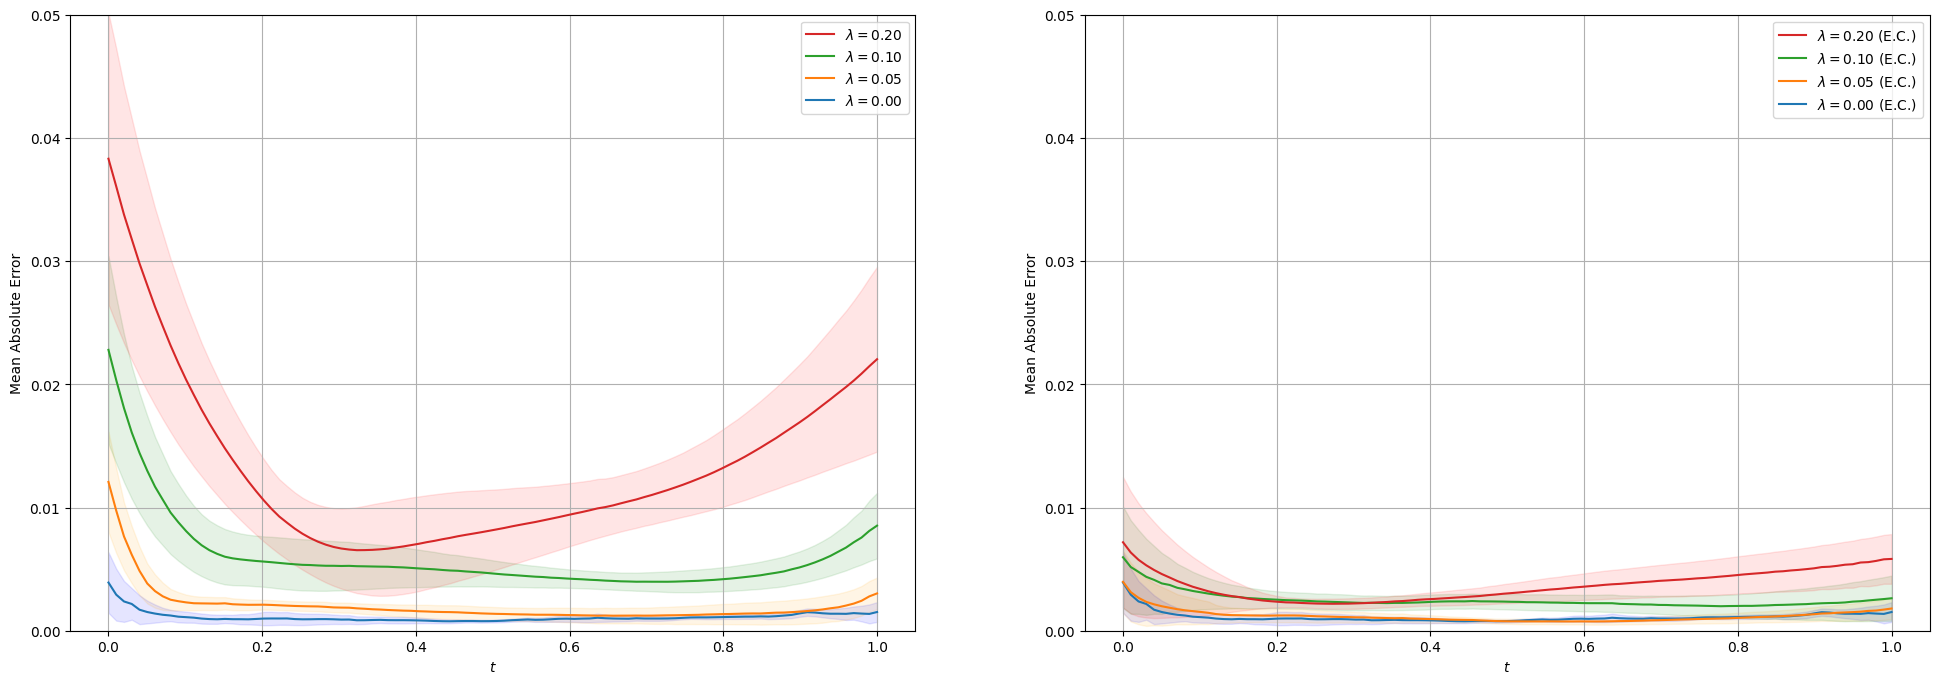

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].plot(t_span, t_abs_error000['mean'], label=r'$\lambda=0.00$')
ax[0].fill_between(t_span, t_abs_error000['mean']-t_abs_error000['std'], t_abs_error000['mean']+t_abs_error000['std'], color='blue', alpha=0.1)
ax[0].plot(t_span, t_abs_error005['mean'], label=r'$\lambda=0.05$')
ax[0].fill_between(t_span, t_abs_error005['mean']-t_abs_error005['std'], t_abs_error005['mean']+t_abs_error005['std'], color='orange', alpha=0.1)
ax[0].plot(t_span, t_abs_error010['mean'], label=r'$\lambda=0.10$')
ax[0].fill_between(t_span, t_abs_error010['mean']-t_abs_error010['std'], t_abs_error010['mean']+t_abs_error010['std'], color='green', alpha=0.1)
ax[0].plot(t_span, t_abs_error020['mean'], label=r'$\lambda=0.20$')
ax[0].fill_between(t_span, t_abs_error020['mean']-t_abs_error020['std'], t_abs_error020['mean']+t_abs_error020['std'], color='red', alpha=0.1)
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('Mean Absolute Error')
# add legend in ax[0]
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc='upper right')
ax[0].grid()
ax[0].set_ylim([0, 0.05])
# set log scale to y axis

ax[1].plot(t_span, t_abs_error000_cal['mean'], label=r'$\lambda=0.00$ (E.C.)')
ax[1].fill_between(t_span, t_abs_error000_cal['mean']-t_abs_error000_cal['std'], t_abs_error000_cal['mean']+t_abs_error000_cal['std'], color='blue', alpha=0.1)
ax[1].plot(t_span, t_abs_error005_cal['mean'], label=r'$\lambda=0.05$ (E.C.)')
ax[1].fill_between(t_span, t_abs_error005_cal['mean']-t_abs_error005_cal['std'], t_abs_error005_cal['mean']+t_abs_error005_cal['std'], color='orange', alpha=0.1)
ax[1].plot(t_span, t_abs_error010_cal['mean'], label=r'$\lambda=0.10$ (E.C.)')
ax[1].fill_between(t_span, t_abs_error010_cal['mean']-t_abs_error010_cal['std'], t_abs_error010_cal['mean']+t_abs_error010_cal['std'], color='green', alpha=0.1)
ax[1].plot(t_span, t_abs_error020_cal['mean'], label=r'$\lambda=0.20$ (E.C.)')
ax[1].fill_between(t_span, t_abs_error020_cal['mean']-t_abs_error020_cal['std'], t_abs_error020_cal['mean']+t_abs_error020_cal['std'], color='red', alpha=0.1)
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('Mean Absolute Error')
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], loc='upper right')
ax[1].grid()
ax[1].set_ylim([0, 0.05])

In [64]:
fig.savefig('../assets/burgers_exp3.png', bbox_inches='tight')